In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import optuna
import joblib

### EDA

In [6]:
data_train = pd.read_csv('data/train.csv')
data_train

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364
299998,299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080


Поскольку таргет в тестовой части нам неизвестен, выделим часть трейновой части для валидации созданных моделей

In [7]:
X = data_train.drop('Price', axis=1)
y = data_train['Price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=8)

Пропуски в данных

In [8]:
# Сразу удалим признак id как не несущий полезной информации
X_train = X_train.drop('id', axis=1)
X_val = X_val.drop('id', axis=1)

X_train.isna().sum()

Brand                   7294
Material                6268
Size                    4914
Compartments               0
Laptop Compartment      5561
Waterproof              5215
Style                   5913
Color                   7514
Weight Capacity (kg)     111
dtype: int64

In [9]:
X_val.isna().sum()

Brand                   2411
Material                2079
Size                    1681
Compartments               0
Laptop Compartment      1883
Waterproof              1835
Style                   2057
Color                   2436
Weight Capacity (kg)      27
dtype: int64

In [10]:
X_train.describe(include='object')

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
count,217706,218732,220086,219439,219785,219087,217486
unique,5,4,3,2,2,3,6
top,Adidas,Polyester,Medium,Yes,Yes,Messenger,Pink
freq,45200,59720,76552,111344,111100,75040,38813


In [11]:
X_train.describe()

,Compartments,Weight Capacity (kg)
count,225000.000000,224889.000000
mean,5.442538,18.040247
std,2.891775,6.972472
min,1.000000,5.000000
25%,3.000000,12.099788
50%,5.000000,18.077288
75%,8.000000,24.038977
max,10.000000,30.000000


In [12]:
# Заменим пропущенные данные в категориальных признаках на `no info`
categorical_cols = X_train.select_dtypes('object').columns.to_list()
X_train[categorical_cols] = X_train[categorical_cols].fillna('no info')
X_val[categorical_cols] = X_val[categorical_cols].fillna('no info')

# Заменим пропущенные данные в числовых признаках на медиану
numerical_cols = X_train.select_dtypes([int, float]).columns.to_list()
median = X_train['Weight Capacity (kg)'].median()

X_train['Weight Capacity (kg)'] = X_train['Weight Capacity (kg)'].fillna(median)
X_val['Weight Capacity (kg)'] = X_val['Weight Capacity (kg)'].fillna(median)

Выбросы

<Axes: xlabel='Weight Capacity (kg)', ylabel='Count'>

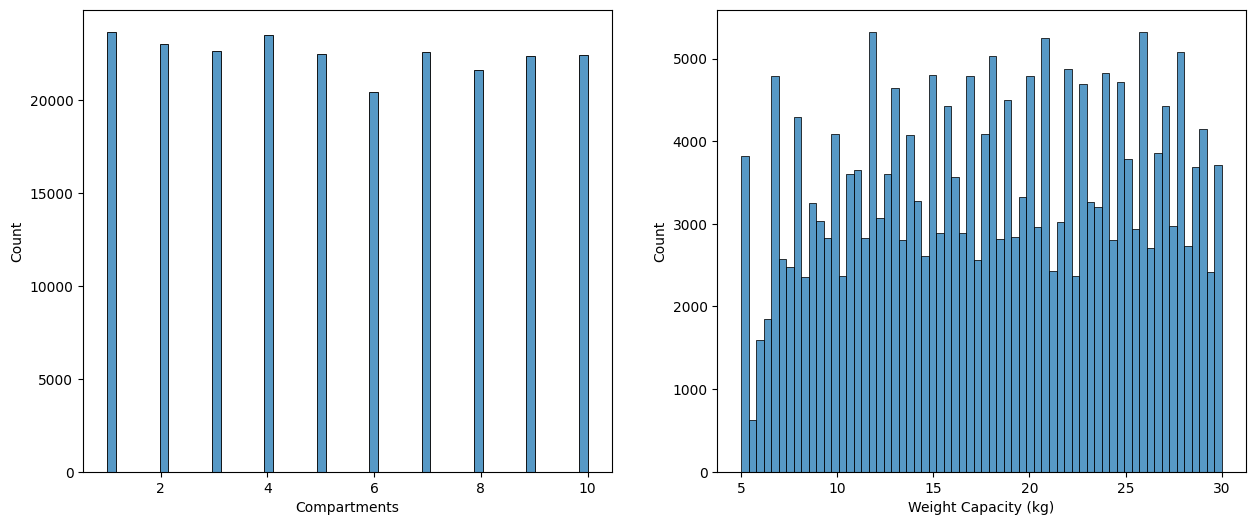

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 6))
sns.histplot(data=X_train, x='Compartments',ax=axes[0])
sns.histplot(data=X_train, x='Weight Capacity (kg)',ax=axes[1])

Корреляции

In [32]:
pd.crosstab(X_train['Brand'], X_train['target'])

KeyError: 'target'

### Baseline

In [75]:
X_train.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
257342,Adidas,Canvas,Large,7.0,No,Yes,Messenger,Pink,8.667768
1230,Adidas,Leather,no info,8.0,No,Yes,Messenger,Blue,15.085735
126968,Under Armour,Canvas,Small,2.0,No,Yes,Tote,Gray,24.907312
136997,Nike,Nylon,Medium,1.0,Yes,Yes,Backpack,Green,17.132315
162570,Jansport,Polyester,Small,2.0,Yes,No,Backpack,Red,29.558365


In [13]:
# Преобразование числовых столбцов
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # Масштабирование непрерывных числовых признаков
])

categorical_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder())  # Масштабирование категориальных признаков
])

# Объединяем преобразования с помощью ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {'regressor__alpha': np.logspace(-1, 2, 10)}

# Настройка GridSearchCV
gs_lr = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

# Обучаем модели с различными гиперпараметрами
gs_lr.fit(X_train, y_train)


y_pred = gs_lr.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.3f}')
print(f'Target mean value: {y_val.mean():.3f}')
print(gs_lr.best_params_)

RMSE: 38.974
Target mean value: 81.436
{'regressor__alpha': 100.0}


### Catboost

In [33]:
cb = CatBoostRegressor(cat_features=categorical_cols, logging_level='Silent')

cb.fit(X_train, y_train)
y_pred = cb.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f'RMSE: {rmse:.3f}')
print(f'Target mean value: {y_val.mean():.3f}')

RMSE: 38.988
Target mean value: 81.436


Для дальнейших экспериментов, уменьшим размер X_train и X_val до 10000

In [81]:
X_train = X_train.iloc[:10000, :]
y_train = y_train.iloc[:10000]
X_val = X_val.iloc[:10000, :]
y_val = y_val.iloc[:10000]

### CatBoost + Optuna

In [46]:
def objective(trial):
    # Определяем гиперпараметры для оптимизации
    iterations = trial.suggest_int('iterations', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1, log=True)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.01, 1, log=True)


    # Создаем модель
    model = CatBoostRegressor(cat_features=categorical_cols,
                              iterations=iterations,
                              depth=depth,
                              learning_rate=learning_rate,
                              l2_leaf_reg=l2_leaf_reg,
                              logging_level='Silent',
                              random_state=42)


    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)

    return rmse

In [47]:
# Создаем Bayesian Optimization
study_cb = optuna.create_study()

# Запускаем Bayesian Optimization
study_cb.optimize(objective, n_trials=30)

best_params_cb = study_cb.best_params

[I 2025-02-27 19:57:12,033] A new study created in memory with name: no-name-daedc55d-1104-4844-ae2f-0c3ab20e6edf
[I 2025-02-27 19:57:56,002] Trial 0 finished with value: 38.96332137282515 and parameters: {'iterations': 937, 'learning_rate': 0.013778228414203115, 'depth': 7, 'l2_leaf_reg': 0.45649356996024626}. Best is trial 0 with value: 38.96332137282515.
[I 2025-02-27 19:58:09,777] Trial 1 finished with value: 38.96236252249356 and parameters: {'iterations': 396, 'learning_rate': 0.04251588028170125, 'depth': 5, 'l2_leaf_reg': 0.3238551899342637}. Best is trial 1 with value: 38.96236252249356.
[I 2025-02-27 19:58:23,650] Trial 2 finished with value: 38.964128852501204 and parameters: {'iterations': 302, 'learning_rate': 0.043195545430583356, 'depth': 7, 'l2_leaf_reg': 0.8971691262326857}. Best is trial 1 with value: 38.96236252249356.
[I 2025-02-27 19:59:03,440] Trial 3 finished with value: 38.98940693966607 and parameters: {'iterations': 519, 'learning_rate': 0.10386654943326806, '

In [48]:
# Создаем модель с лучшими гиперпараметрами
best_cb_model = CatBoostRegressor(cat_features=categorical_cols,
                                  logging_level='Silent',
                                  **best_params_cb)

best_cb_model.fit(X_train, y_train)

# joblib.dump(best_cb_model,'best_cb_model.joblib')

y_pred = best_cb_model.predict(X_val)
rmse_optuna = root_mean_squared_error(y_val, y_pred)

print(f'CatBoost + optuna RMSE: {rmse_optuna:.5f}')

CatBoost + optuna RMSE: 38.96453


### RandomForest

In [17]:
# Кодируем категориальные признаки при помощи OneHotEncoder
ohe_enc = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False).set_output(transform='pandas')

X_train_encoded = ohe_enc.fit_transform(X_train[categorical_cols])
X_val_encoded = ohe_enc.transform(X_val[categorical_cols])

In [51]:
def objective_rf(trial):
    # Определите гиперпараметры для подбора
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    }

    model = RandomForestRegressor(criterion='squared_error', **params)
    model.fit(X_train_encoded, y_train)

    y_pred = model.predict(X_val_encoded)
    rmse = root_mean_squared_error(y_val, y_pred)

    return rmse

# Запуск оптимизации
study_rf = optuna.create_study()
study_rf.optimize(objective_rf, n_trials=30)
best_params_rf = study_rf.best_params

[I 2025-02-27 20:24:42,192] A new study created in memory with name: no-name-116ff855-f2f7-4824-9792-5f2192a8cb1a
[I 2025-02-27 20:24:45,137] Trial 0 finished with value: 38.98192978511063 and parameters: {'n_estimators': 67, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 38.98192978511063.
[I 2025-02-27 20:25:04,104] Trial 1 finished with value: 38.98022891745636 and parameters: {'n_estimators': 128, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 1 with value: 38.98022891745636.
[I 2025-02-27 20:25:15,978] Trial 2 finished with value: 39.00017987677866 and parameters: {'n_estimators': 55, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 1 with value: 38.98022891745636.
[I 2025-02-27 20:25:20,047] Trial 3 finished with value: 38.980217650290626 and parameters: {'n_estimators': 84, 'max_depth': 6, 'min_samples_

In [52]:
best_rf_model = RandomForestRegressor(**best_params_rf)
best_rf_model.fit(X_train_encoded, y_train)

# joblib.dump(best_rf_model,'best_rf_model.joblib')

y_pred = best_rf_model.predict(X_val_encoded)
rmse_optuna = root_mean_squared_error(y_val, y_pred)

print(f'RandomForest + optuna RMSE: {rmse_optuna:.5f}')

RandomForest + optuna RMSE: 38.98027


### XGBoost

In [21]:
def objective(trial):
    # Определяем гиперпараметры для оптимизации
    params={
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'gamma': trial.suggest_float('gamma', 0.01, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Создаем модель
    model = XGBRegressor(**params)
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_val_encoded)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

# Создаем Bayesian Optimization
study = optuna.create_study()
# Запускаем Bayesian Optimization
study.optimize(objective, n_trials=100)
best_params_xgb = study.best_params
# Создаем модель с лучшими гиперпараметрами
best_xgb_model = XGBRegressor(**best_params_xgb)
best_xgb_model.fit(X_train_encoded, y_train)

y_pred = best_xgb_model.predict(X_val_encoded)
rmse_optuna = root_mean_squared_error(y_val, y_pred)

print(f'XGBoost + optuna RMSE: {rmse_optuna:.5f}')

[I 2025-02-27 12:21:00,219] A new study created in memory with name: no-name-b066d040-4a5a-41a0-98fc-4edb2ab163cd
[I 2025-02-27 12:21:03,651] Trial 0 finished with value: 39.560161873281594 and parameters: {'max_depth': 10, 'learning_rate': 0.09897165793735672, 'n_estimators': 289, 'gamma': 0.08381727933238212, 'subsample': 0.7013907149452192, 'colsample_bytree': 0.8373323600102804, 'reg_alpha': 1.692184201634086, 'reg_lambda': 0.212906139257693, 'min_child_weight': 9}. Best is trial 0 with value: 39.560161873281594.
[I 2025-02-27 12:21:04,318] Trial 1 finished with value: 38.983070572549636 and parameters: {'max_depth': 1, 'learning_rate': 0.024963005517077513, 'n_estimators': 239, 'gamma': 2.6622973603511433, 'subsample': 0.7621858301123543, 'colsample_bytree': 0.882280218546126, 'reg_alpha': 8.994736375798752, 'reg_lambda': 2.2598564995063404, 'min_child_weight': 5}. Best is trial 1 with value: 38.983070572549636.
[I 2025-02-27 12:21:05,194] Trial 2 finished with value: 38.980001003

XGBoost + optuna RMSE: 38.97663


In [19]:
# joblib.dump(xgb_model,'best_xgb_model.joblib')

['best_xgb_model.joblib']

Загрузка лучших из ранее полученных моделей

In [53]:
# rf_model = joblib.load('best_rf_model.joblib')
# xgb_model = joblib.load('best_rf_model.joblib')
best_cb_model = joblib.load('best_cb_model.joblib')

### Stacking

In [54]:
# Создание пайплайна для Random Forest с One-Hot Encoding
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('passthrough', 'passthrough', numerical_cols)
    ]
)

# rf_model = joblib.load('best_rf_model.joblib')
rf_model = best_rf_model

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_rf),
                               ('model', rf_model)])

# Создание пайплайна для XGBoost с One-Hot Encoding
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('passthrough', 'passthrough', numerical_cols)
    ]
)

# xgb_model = joblib.load('best_rf_model.joblib')
xgb_model = best_xgb_model

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor_xgb),
                               ('model', xgb_model)])


# Создание пайплайна для LinearRegression с One-Hot Encoding
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('passthrough', 'passthrough', numerical_cols)
    ]
)

# xgb_model = joblib.load('best_rf_model.joblib')
lr_model = Ridge(alpha=10)

lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor_lr),
                               ('model', xgb_model)])

In [55]:
# Определите базовые модели

# cb_model = joblib.load('best_cb_model.joblib')

base_models = [
    # ('xgboost', xgb_pipeline),
    ('random_forest', rf_pipeline),
    ('catboost', best_cb_model)
]

# Мета-алгоритм
# meta_model = CatBoostRegressor(iterations=300,
#                                learning_rate=0.05,
#                                depth=8,
#                                l2_leaf_reg=0.07,
#                                logging_level='Silent')
meta_model = Ridge(alpha=100)
# meta_model = Ridge(alpha=10)
# meta_model = RandomForestRegressor(**best_params_rf)
# meta_model = CatBoostRegressor(iterations=300, learning_rate=0.03, depth=6, l2_leaf_reg=0.6, silent=True)

# Создание стекинг-модели
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

'iterations': 282, 'learning_rate': 0.03059899787943897, 'depth': 6, 'l2_leaf_reg': 0.5864592415216597

In [56]:
# Обучение стекинг-модели
stacked_model.fit(X_train, y_train)

# Прогнозирование
predictions = stacked_model.predict(X_val)

rmse_stack = root_mean_squared_error(y_val, predictions)

print(f'Stacked models RMSE: {rmse_stack:.5f}')

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=4]="No": Cannot convert 'b'No'' to float

### Test and submission

Поскольку для тестирование модели имеется отдельный датасет, можно заново обучить нашу итоговую модель на объединенных данных (train + val)

In [41]:
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

# Обучение итоговой модели
stacked_model.fit(X_train_full, y_train_full)
df_test = pd.read_csv('data/test.csv')
submission = pd.DataFrame()
submission['id'] = df_test['id']
X_test = df_test.drop('id', axis=1)

# Заменим пропущенные данные в категориальных признаках на `no info`
X_test[categorical_cols] = X_test[categorical_cols].fillna('no info')

# Заменим пропущенные данные в числовых признаках на медиану
X_test['Weight Capacity (kg)'] = X_test['Weight Capacity (kg)'].fillna(median)


y_pred = stacked_model.predict(X_test)
submission['Price'] = np.round(y_pred, 3)
submission.head()

,id,Price
0,300000,82.019
1,300001,82.703
2,300002,81.995
3,300003,81.614
4,300004,79.180


In [43]:
submission.to_csv('data/submission.csv', index=False)